In [104]:
import matplotlib.pyplot as plt
from math import sin,cos,pi
import numpy as np
import sys
import math
import cv2
from google.colab.patches import cv2_imshow
from scipy.special import lambertw
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)

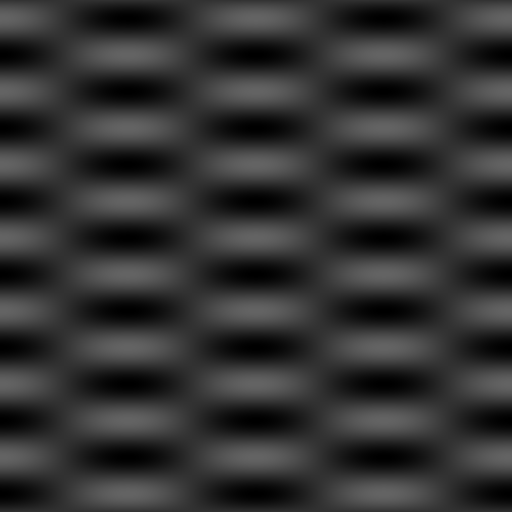

In [105]:
#Question B
A = 2500
Wx = 2
Wy = 7

def mean_val_at_range(area, x_h, x_l, y_h, y_l):
  return (-1*A*(1/area)*(1/(4*pi*pi*Wx*Wy))
          *(sin(2*pi*Wx*x_h)-sin(2*pi*Wx*x_l))
          *(cos(2*pi*Wy*y_h)-cos(2*pi*Wy*y_l))) #integrating over the range and dividing by the area

def get_sample_mat(Nx, Ny):
  num_mat = np.empty([Ny, Nx])
  for i in range(Ny):
    for j in range(Nx):
      num_mat[i, j] = mean_val_at_range(float(1)/(Nx*Ny), float(j+1)/Nx,
                                       float(j)/Nx, float(i+1)/Ny, float(i)/Ny)
  return num_mat


x_samp = 512
y_samp = 512
img_size = (x_samp, y_samp)
init_mat = get_sample_mat(x_samp, y_samp)
grayscale_mat = ((init_mat/(2*A))*100 + 50).astype('float64')
#print(np.matrix(grayscale_mat))
cv2_imshow(grayscale_mat) 
img = cv2.imwrite("image1.jpg", grayscale_mat) 

In [106]:
#Question C
def get_derivative_matrix(sample_mat, axis):
  derivative_mat = np.empty(sample_mat.shape)
  y_size = sample_mat.shape[0]
  x_size = sample_mat.shape[1]
  if axis == 'x':
    size = x_size
  else:
    size = y_size
  for i in range(y_size):
    for j in range(x_size):
      if axis == 'x':
        approx = sample_mat[i, (j+1) % x_size]
      else:
        approx = sample_mat[(i+1) % y_size, j]
      derivative_mat[i,j] = (approx - sample_mat[i,j]) * size
  return derivative_mat

phi_h = np.amax(init_mat)
phi_l = np.amin(init_mat)
phi_range = phi_h - phi_l
area = init_mat.shape[0] * init_mat.shape[1]
x_der = get_derivative_matrix(init_mat, 'x')
y_der = get_derivative_matrix(init_mat, 'y')
horizontal_deriv_energy = np.sum(np.square(x_der) / area)
vertical_deriv_energy = np.sum(np.square(y_der) / area)
print("Range is: ", phi_range)
print("Horizontal derivative energy is: ", horizontal_deriv_energy)
print("Vertical derivative energy is: ", vertical_deriv_energy)
horiz_error = abs((3.02 * pow(10, 9) - horizontal_deriv_energy) / (100 * 3.02 * pow(10, 9)))
vert_error = abs((2.47 * pow(10, 8) - vertical_deriv_energy) / (100 * 2.47 * pow(10, 8)))
print("Horizontal derivative energy error is:", format(horiz_error, ".9f"), "%")
print("Vertical derivative energy error is:", format(vert_error, ".9f"), "%")

Range is:  4997.8668752656495
Horizontal derivative energy is:  246563660.2512485
Vertical derivative energy is:  3018699452.86044
Horizontal derivative energy error is: 0.009183564 %
Vertical derivative energy error is: 0.112214553 %


In [107]:
#Question D
def get_MSE(b, Nx, Ny, phi_range, x_deriv_energy, y_deriv_energy):
  try:
    return ((x_deriv_energy / (12 * (Nx ** 2))) + (y_deriv_energy / (12 * (Ny ** 2)))\
          + ((phi_range ** 2) / (12 * (2 ** (2 * b)))))
  except OverflowError as e:
    return sys.maxsize

def get_bit_alloc(bit_budget, phi_range, x_deriv_energy, y_deriv_energy):
  deriv_energy = phi_range * (x_deriv_energy + y_deriv_energy) / 2.2 
  lambert_arg = np.log(4) * (((phi_range ** 2) * np.log(2) * (bit_budget ** 2))  / deriv_energy)
  b = lambertw(lambert_arg, k=0) / np.log(4)
  Nx = np.sqrt((np.sqrt(x_deriv_energy) * bit_budget) / (np.sqrt(y_deriv_energy) * b))
  b_floor = math.floor(b)
  b_ceil = math.ceil(b)
  Nx_floor = math.floor(Nx)
  Nx_ceil = math.ceil(Nx)
  round_args = [(Nx_ceil, b_ceil, math.floor(bit_budget / (Nx_ceil * b_ceil))),
                (Nx_ceil, b_floor, math.floor(bit_budget / (Nx_ceil * b_floor))),
                (Nx_floor, b_ceil, math.floor(bit_budget / (Nx_floor * b_ceil))),
                (Nx_floor, b_floor, math.floor(bit_budget / (Nx_floor * b_floor)))]
  optimal_MSE = sys.maxsize
  Ny = sys.maxsize
  for args in round_args:
    current_Nx, current_b, current_Ny = args
    current_MSE = get_MSE(current_b, current_Nx, current_Ny, phi_range, x_deriv_energy, y_deriv_energy)
    if (current_MSE < optimal_MSE):
      optimal_MSE, Nx, Ny, b = current_MSE, current_Nx, current_Ny, current_b
  return (optimal_MSE, Nx, Ny, b)

In [108]:
#Question E
low_B = 5000
high_B = 50000
bit_alloc_numeric_low = get_bit_alloc(low_B, phi_range,horizontal_deriv_energy, vertical_deriv_energy) 
bit_alloc_numeric_high = get_bit_alloc(high_B, phi_range,horizontal_deriv_energy, vertical_deriv_energy)
print("Low: \nNx = %d, Ny = %d, b = %d\n" % bit_alloc_numeric_low[1:4]) 
print("High: \nNx = %d, Ny = %d, b = %d" % bit_alloc_numeric_high[1:4])

Low: 
Nx = 24, Ny = 69, b = 3

High: 
Nx = 54, Ny = 185, b = 5


In [109]:
#Question F
def search_optimal_bit_alloc_params(bit_budget, phi_range, x_deriv_energy, y_deriv_energy):
  b, Nx = 1, 1
  Ny = math.floor(bit_budget / (b * Nx))
  optimal_MSE = get_MSE(b, Nx, Ny, phi_range, x_deriv_energy, y_deriv_energy)
  for bits in range(1, bit_budget):
    for x_size in range(1, math.ceil(bit_budget / float(bits))):
      y_size = math.floor(bit_budget / (bits * x_size))
      if (y_size > 0):
        current_MSE = get_MSE(bits, x_size, y_size, phi_range, x_deriv_energy, y_deriv_energy)
        if (optimal_MSE > current_MSE):
          optimal_MSE, b, Nx, Ny = current_MSE, bits, x_size, y_size
  return (optimal_MSE, Nx, Ny, b)

search_bit_alloc_low = search_optimal_bit_alloc_params(low_B, phi_range, horizontal_deriv_energy, vertical_deriv_energy)
search_bit_alloc_high = search_optimal_bit_alloc_params(high_B, phi_range, horizontal_deriv_energy, vertical_deriv_energy)
print("Low: \nNx = %d, Ny = %d, b = %d\n" % search_bit_alloc_low[1:]) 
print("High: \nNx = %d, Ny = %d, b = %d" % search_bit_alloc_high[1:])

Low: 
Nx = 21, Ny = 79, b = 3

High: 
Nx = 54, Ny = 185, b = 5


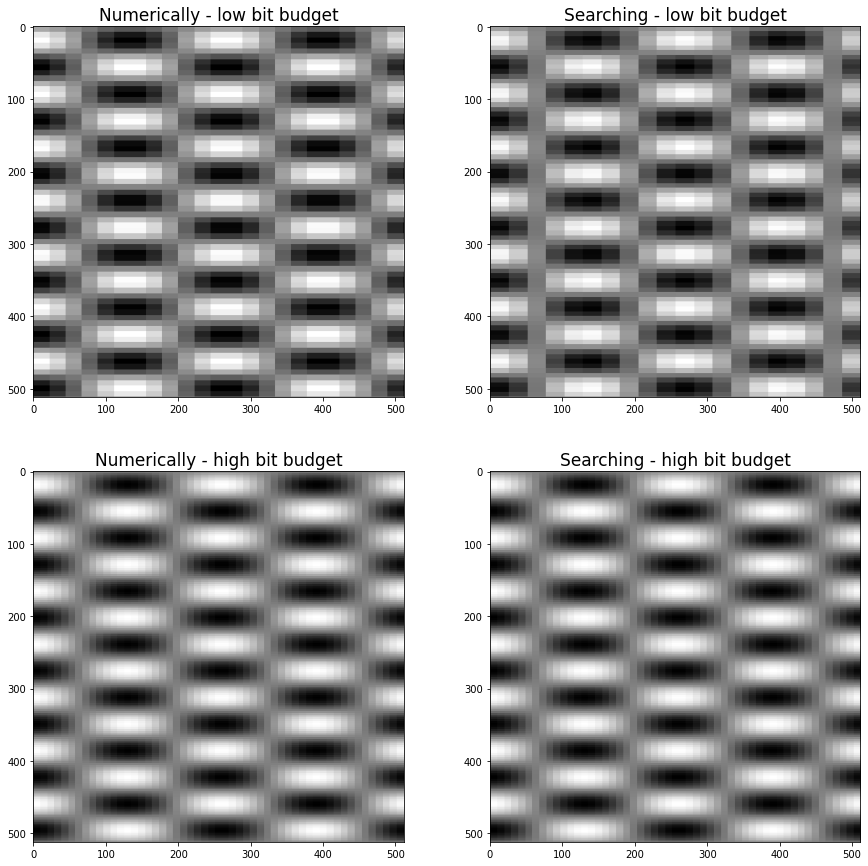

In [110]:
#Question G
def quantize(levels, element_val):
    return element_val - ((levels * element_val) % 1) / levels + (1 / (2 * levels))

def make_digital(bit_alloc):
  samp_mat = get_sample_mat(bit_alloc[1],bit_alloc[2])
  dgtz_mat = np.empty(img_size)
  for i in range(dgtz_mat.shape[0]):
    for j in range(dgtz_mat.shape[1]):
      value_of_cell = samp_mat[math.floor(i * (bit_alloc[2] - 1) / 
                              (dgtz_mat.shape[1] - 1)), math.floor(j * (bit_alloc[1] - 1) / 
                              (dgtz_mat.shape[0] - 1))]
      dgtz_mat[i,j] = quantize(bit_alloc[3], value_of_cell)
  return dgtz_mat, samp_mat

def print_imgs(list_of_mat, title_list, img_name):
    plt.figure(figsize=(15, 15))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.title(title_list[i], fontsize=17)
        plt.imshow(list_of_mat[i], cmap='gray')
    plt.savefig(f"{img_name}.jpg")

print_imgs([make_digital(bit_alloc_numeric_low)[0], make_digital(search_bit_alloc_low)[0],
            make_digital(bit_alloc_numeric_high)[0], make_digital(search_bit_alloc_high)[0]],
           ["Numerically - low bit budget", "Searching - low bit budget",
            "Numerically - high bit budget", "Searching - high bit budget"], 'image2')

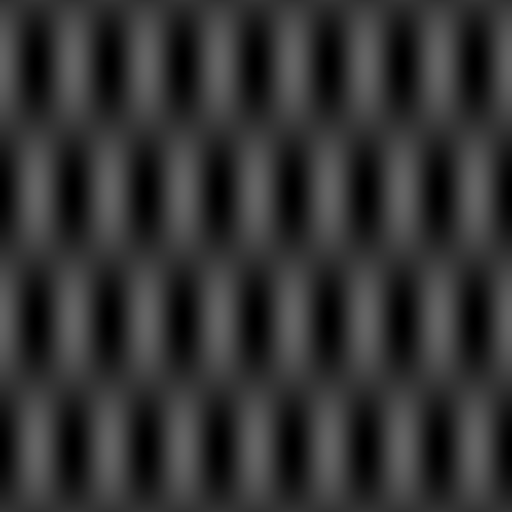

In [111]:
#Question H
A = 2500
Wx = 7
Wy = 2

x_samp = 512
y_samp = 512
img_size = (x_samp, y_samp)
init_mat = get_sample_mat(x_samp, y_samp)
grayscale_mat = ((init_mat/(2*A))*100 + 50).astype('float64')
#print(np.matrix(grayscale_mat))
cv2_imshow(grayscale_mat) 
img = cv2.imwrite("image3.jpg", grayscale_mat) 



In [112]:
phi_h = np.amax(init_mat)
phi_l = np.amin(init_mat)
phi_range = phi_h - phi_l
area = init_mat.shape[0] * init_mat.shape[1]
x_der = get_derivative_matrix(init_mat, 'x')
y_der = get_derivative_matrix(init_mat, 'y')
horizontal_deriv_energy = np.sum(np.square(x_der) / area)
vertical_deriv_energy = np.sum(np.square(y_der) / area)
print("Range is: ", phi_range)
print("Horizontal derivative energy is: ", horizontal_deriv_energy)
print("Vertical derivative energy is: ", vertical_deriv_energy)
horiz_error = abs((3.02 * pow(10, 9) - horizontal_deriv_energy) / (100 * 3.02 * pow(10, 9)))
vert_error = abs((2.47 * pow(10, 8) - vertical_deriv_energy) / (100 * 2.47 * pow(10, 8)))
print("Horizontal derivative energy error is:", format(horiz_error, ".9f"), "%")
print("Vertical derivative energy error is:", format(vert_error, ".9f"), "%")

Range is:  4997.86687526565
Horizontal derivative energy is:  3018699452.8604403
Vertical derivative energy is:  246563660.25124842
Horizontal derivative energy error is: 0.000004306 %
Vertical derivative energy error is: 0.000017666 %


In [113]:
low_B = 5000
high_B = 50000
bit_alloc_numeric_low = get_bit_alloc(low_B, phi_range,horizontal_deriv_energy, vertical_deriv_energy) 
bit_alloc_numeric_high = get_bit_alloc(high_B, phi_range,horizontal_deriv_energy, vertical_deriv_energy)
print("Low: \nNx = %d, Ny = %d, b = %d\n" % bit_alloc_numeric_low[1:4]) 
print("High: \nNx = %d, Ny = %d, b = %d" % bit_alloc_numeric_high[1:4])

Low: 
Nx = 87, Ny = 19, b = 3

High: 
Nx = 185, Ny = 54, b = 5


In [114]:
search_bit_alloc_low = search_optimal_bit_alloc_params(low_B, phi_range, horizontal_deriv_energy, vertical_deriv_energy)
search_bit_alloc_high = search_optimal_bit_alloc_params(high_B, phi_range, horizontal_deriv_energy, vertical_deriv_energy)
print("Low: \nNx = %d, Ny = %d, b = %d\n" % search_bit_alloc_low[1:]) 
print("High: \nNx = %d, Ny = %d, b = %d" % search_bit_alloc_high[1:])

Low: 
Nx = 79, Ny = 21, b = 3

High: 
Nx = 185, Ny = 54, b = 5


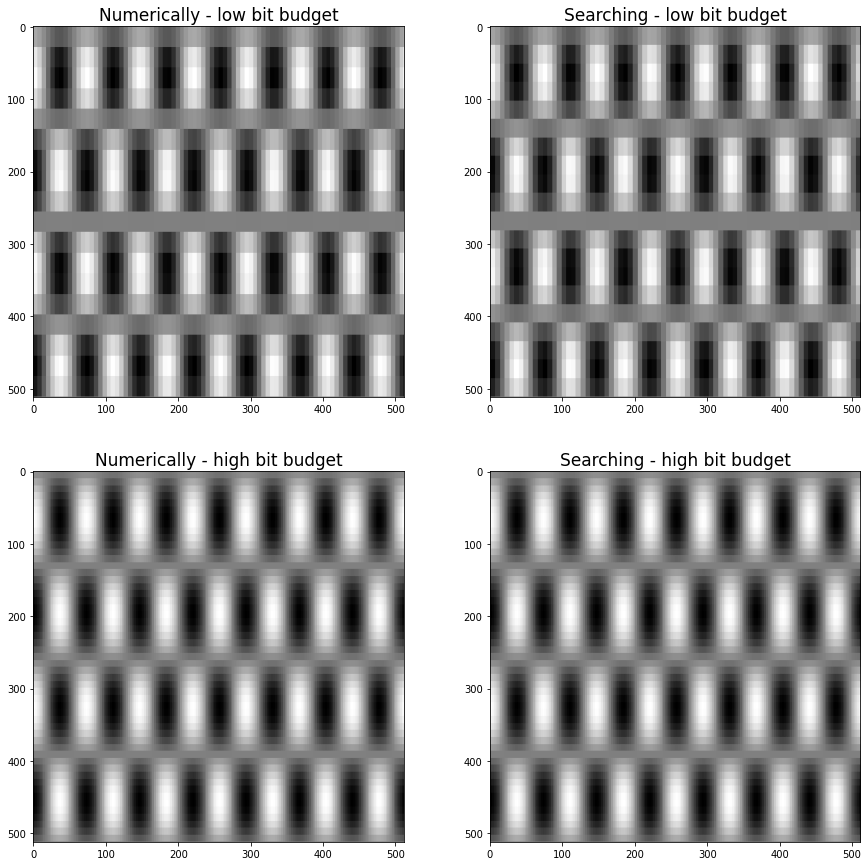

In [115]:
print_imgs([make_digital(bit_alloc_numeric_low)[0], make_digital(search_bit_alloc_low)[0],
            make_digital(bit_alloc_numeric_high)[0], make_digital(search_bit_alloc_high)[0]],
           ["Numerically - low bit budget", "Searching - low bit budget",
            "Numerically - high bit budget", "Searching - high bit budget"], 'image4')